# Fetch and load PDB
This code acquires the pdb file from the RCSB databank, loads the necessary information, and saves copies for possible use in visualization in other software.

In [1]:
from pyCapsid.PDB import getCapsid
pdb = '7kq5'
capsid, calphas, coords, bfactors, chain_starts, title = getCapsid(pdb, save=True)

Fetching file 1 / 1 (7kq5)...
Done


C:\Users\colin\miniconda3\envs\pycapsid_local\lib\site-packages\biopython-1.80-py3.10-win-amd64.egg\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
@> 4507 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> Secondary structures were assigned to 195 residues.
@> Biomolecular transformations were applied to the coordinate data.
@> 4507 atoms and 1 coordinate set(s) were parsed in 0.04s.


Number Of Residues:  15900
Writing complete capsid PDB


@> WARNING hybrid36 format is being used


# Build ENM Hessian
This code builds a hessian matrix using an elastic network model defined by the given parameters. The types of model and the meaning of the parameters are provided in the documentation.

In [2]:
from pyCapsid.ENM import buildENMPreset
kirch, hessian = buildENMPreset(coords, preset='U-ENM')

Building hessian for model preset:  U-ENM
Model parameters:  {'cutoff': 7.5, 'gnm': False, 'fanm': 0.1, 'wfunc': 'power', 'base_dist': 1, 'd_power': 0, 'backbone': False, 'k_backbone': 1, 'l_backbone': 1, 'chain_starts': None}
Finding neighbors within 7.5Å
Building kirchhoff matrix
Building hessian matrix
Done building model


# Perform NMA
## Calculate low frequency modes
This code calculates the n lowest frequency modes of the system by calculating the eigenvalues and eigenvectors of the hessian matrix.

In [3]:
from pyCapsid.NMA import modeCalc
n_modes = 100
eigmethod = 'eigsh'

evals, evecs = modeCalc(hessian, n_modes, eigmethod=eigmethod)

Calculating Normal Modes
NMA time:  39.063998222351074


## Predict, fit, and compare b-factors
This code uses the resulting normal modes and frequencies to predict the b-factors of each alpha carbon, fits these results to experimental values from the pdb entry, and plots the results for comparison.

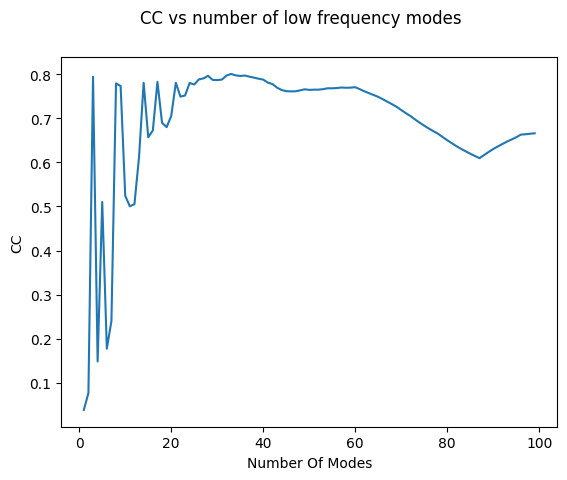

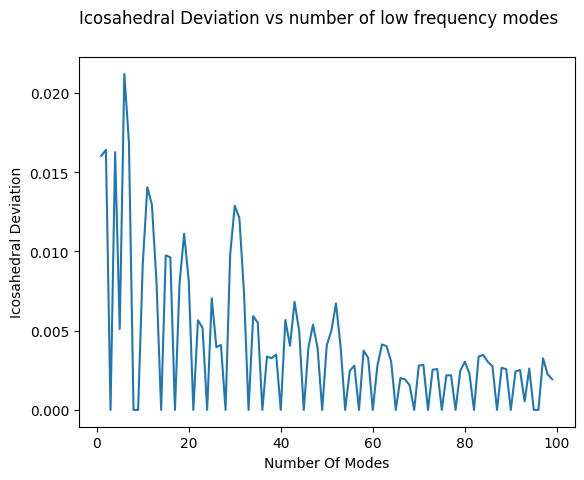

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                15900
Model:                            RLM   Df Residuals:                    15899
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 06 Feb 2023                                         
Time:                        14:52:53                                         
No. Iterations:                    38                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           107.6567      0.145    744.669      0.0

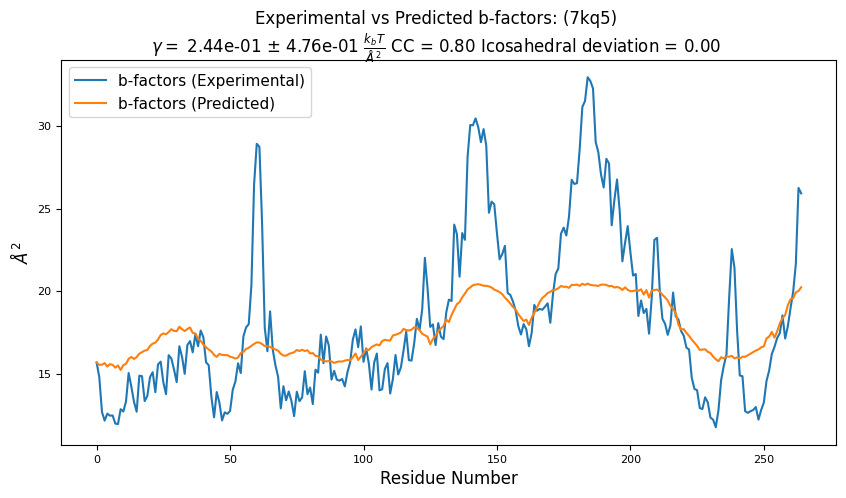

(0.8005052290311508,
 107.65667142322027,
 0,
 array([15.67505366, 15.55165095, 15.55065438, ..., 19.48782533,
        19.56536048, 19.77225004]),
 0.4755924603709616,
 array([0.]),
 2.045494079672139e-09,
 32)

In [4]:
from pyCapsid.bfactorfit import plotBfactors
plotBfactors(evals, evecs, bfactors, pdb, is3d=True, fitModes=True, plotModes=True, forceIco=False, icotol=0.002)

# Perform quasi-rigid cluster identification (QRC)
## Build weighted graph based on distance fluctuations
This code calculates the distance fluctuations between residues within a cutoff distance from each other and transforms those distance fluctuations into a similarity matrix representing a sparse weighted graph.

In [5]:
from pyCapsid.NMA import calcDistFlucts

fluct_cutoff = 10

dist_flucts = calcDistFlucts(evals, evecs, n_modes, coords, fluct_cutoff, is3d=True)
print(dist_flucts.data)

100
Direct Calculation Method
diag:  [0.21451014 0.21082875 0.20971907 ... 0.26593962 0.26761998 0.26827521]
data:  [0.21309914 0.20700861 0.21175692 ... 0.26593962 0.26761998 0.26827521]
[0.01838564 0.0102164  0.01400408 ... 0.         0.         0.        ]
[0.01838564 0.0102164  0.01400408 ... 0.         0.         0.        ]


## Calculate the spectral embedding of the graph
This code calculates the spectral embedding (eigenvectors) of the sparse weighted graph.

RMS distance fluctuations:  0.05000614328136213
Performing Spectral Embedding
(1, array([0, 0, 0, ..., 0, 0, 0]))
Clustering Embedded Points
Clusters: 4
discretize
(4,)
Scoring
Score:  2.7526393245245124
Clusters: 6
discretize
(6,)
Scoring
Score:  3.914185877004358
Clusters: 8
discretize
(8,)
Scoring
Score:  3.061455468881529
Clusters: 10
discretize
(10,)
Scoring
Score:  3.4159316406235782
Clusters: 12
discretize
(12,)
Scoring
Score:  5.3633825153317005
Clusters: 14
discretize
(14,)
Scoring
Score:  3.362993441329264
Clusters: 16
discretize
(16,)
Scoring
Score:  2.615091454607935
Clusters: 18
discretize
(18,)
Scoring
Score:  2.7634051004302647
Clusters: 20
discretize
(20,)
Scoring
Score:  2.86041069691413
Clusters: 22
discretize
(22,)
Scoring
Score:  2.810484521295127
Clusters: 24
discretize
(24,)
Scoring
Score:  2.7576925532218874
Clusters: 26
discretize
(26,)
Scoring
Score:  3.0354908821776707
Clusters: 28
discretize
(28,)
Scoring
Score:  3.0359643753336147
Clusters: 30
discretize
(30

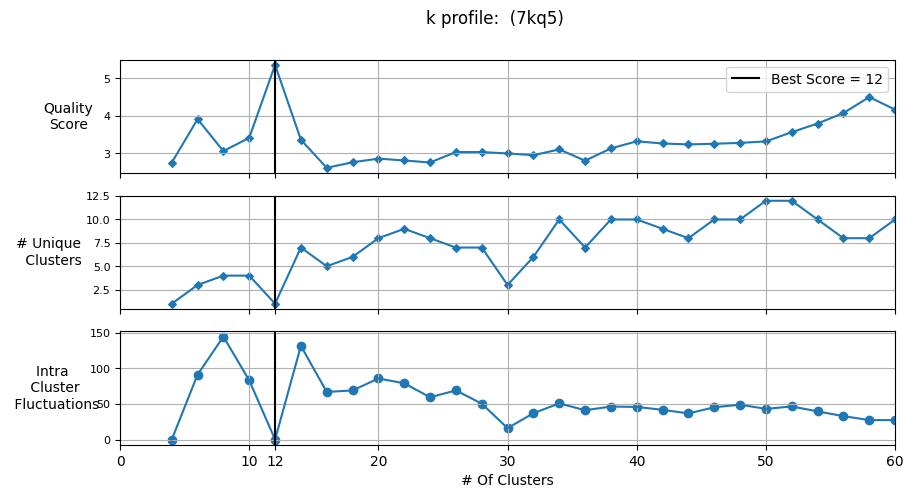

In [6]:
from pyCapsid.QRC import findQuasiRigidClusters
import numpy as np
n_cluster_max = 62
n_range = np.arange(4, n_cluster_max, 2)
labels  = findQuasiRigidClusters(pdb, dist_flucts, n_range)

In [7]:
%load_ext autoreload
%autoreload 2

In [9]:
from pyCapsid.viz_util import chimeraxLaunchTest
import os
print(os.getcwd())
chimeraxLaunchTest(labels[0], pdb_path = '../notebooks/7kq5_capsid.pdb', labels_path='C:/Users/colin/test.npy')

C:\Users\colin\pyCapsid\notebooks
C:/Users/colin/test.npy
C:\Program Files\ChimeraX\bin\ChimeraX.exe
""C:\Program Files\ChimeraX\bin\ChimeraX.exe" --script "../src/pyCapsid/scripts/chimerax_script.py C:/Users/colin/test.npy . ../notebooks/7kq5_capsid.pdb""
???


In [ ]:
# Adapted from py3dmol tutorial
# https://william-dawson.github.io/using-py3dmol.html
class Atom(dict):
    def __init__(self, line):
        self["type"] = line[0:6].strip()
        self["idx"] = line[6:11].strip()
        self["name"] = line[12:16].strip()
        self["resname"] = line[17:20].strip()
        self["resid"] = int(int(line[22:26]))
        self["x"] = float(line[30:38])
        self["y"] = float(line[38:46])
        self["z"] = float(line[46:54])
        self["sym"] = line[76:78].strip()

    def __str__(self):
        line = list(" " * 80)

        line[0:6] = self["type"].ljust(6)
        line[6:11] = self["idx"].ljust(5)
        line[12:16] = self["name"].ljust(4)
        line[17:20] = self["resname"].ljust(3)
        line[22:26] = str(self["resid"]).ljust(4)
        line[30:38] = str(self["x"]).rjust(8)
        line[38:46] = str(self["y"]).rjust(8)
        line[46:54] = str(self["z"]).rjust(8)
        line[76:78] = self["sym"].rjust(2)
        return "".join(line) + "\n"
    
class Molecule(list):
    def __init__(self, file):
        for line in file:
            if "ATOM" in line or "HETATM" in line:
                self.append(Atom(line))

    def __str__(self):
        outstr = ""
        for at in self:
            outstr += str(at)

        return outstr
    
# Colormap generation taken from stackexchange
# https://stackoverflow.com/questions/42697933/colormap-with-maximum-distinguishable-colours
def generate_colormap(number_of_distinct_colors: int = 80):
    import math

    import numpy as np
    from matplotlib.colors import ListedColormap
    from matplotlib.cm import hsv

    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

In [ ]:
with open(pdb + "_capsid.pdb") as ifile:
    mol = Molecule(ifile)

In [ ]:
import numpy as np
print(np.min(clusters))
print('labels: ', clusters.shape)

In [ ]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=np.min(clusters), vmax=np.max(clusters))
cmap = generate_colormap(int(np.max(clusters)))
print(cmap)
rgba = cmap(norm(clusters))
print(rgba*255)
hexcolor = []
for c in rgba:
    hexcolor.append(mpl.colors.rgb2hex(c))

In [ ]:
r0 = mol[0]['resid']
c0 = hexcolor[0]
#l0 = clusters[0]
#fullcolors = []
clust_scheme = []
select = '@'
print(r0, c0)
i = 1
j = 0
for at in mol:
    r = at['resid']
    if r == r0:
        select += str(i) + ','
        i += 1
    else:
        clust_scheme.append([c0, select[:-1]])
        select = '@' + str(i) + ','
        r0 = r
        j +=1
        i +=1
        c0 = hexcolor[j]
        l0 = clusters[j]
clust_scheme.append([c0, select[:-1]])

In [ ]:
import nglview as ngl
file = pdb + '_capsid.pdb'
color_scheme = ngl.color._ColorScheme(clust_scheme, label="scheme_regions")
view = ngl.show_prody(capsid, gui=False)
view.clear_representations()


view.add_representation("spacefill",  color=color_scheme)
view._remote_call("setSize", target='Widget', args=['1000px','1000px'])
view